# Circulant sets of pure quantum states and tight bounds for antidistinguishability

Let $n$ and $d$ be integers and let $\mathcal{X} = \mathbb{C}^d$ represent a complex Euclidean space. A collection of quantum states $\{|\psi_0\rangle, \ldots, |\psi_{n-1}\rangle\} \subset \mathcal{X}$ are *antidistinguishable* if there exists a collection of positive operator value measurements $\{M_0, \ldots, M_{n-1}\}$ such that $\langle \psi_i | M_i | \psi_i \rangle = 0$ for all $0 \leq i \leq n-1$. Recall that a collection of POVMs are positive semidefinite operators $\{M_i : 0 \leq i \leq n-1\} \subset \text{Pos}(\mathcal{X})$ that satisfy 
$$
\sum_{i=0}^{n-1} M_i = \mathbb{I}_{\mathcal{X}}.
$$

The following list of imports will be used throughout the remainder of the notebook.

In [1]:
import numpy as np
import picos
import matplotlib.pyplot as plt
from collections import defaultdict

from toqito.state_props import is_antidistinguishable
from toqito.matrices import standard_basis
from toqito.state_opt import state_exclusion
from toqito.matrix_ops import vectors_from_gram_matrix, vectors_to_gram_matrix

from qiskit.quantum_info.states.random import random_statevector

### Semidefinite program for antidistinguishability

Whether a collection of states $\{|\psi_0 \rangle, \ldots, |\psi_{n-1}\rangle \}$ are antidistinguishable or not can be determined by the following semidefinite program (SDP).

$$
    \begin{equation}
        \begin{aligned}
            \textbf{Primal:} \quad & \\
            \text{minimize:} \quad & \sum_{i=0}^{n-1} \langle \psi_i | M_i | \psi_i \rangle  \\
            \text{subject to:} \quad & \sum_{i=0}^{n-1} M_i = \mathbb{I}_{\mathcal{X}}, \\
                                     & M_i \in \text{Pos}(\mathcal{X}) \quad \forall \ 0 \leq i \leq n-1.
        \end{aligned}
    \end{equation}
$$

$$
    \begin{equation}
        \begin{aligned}
            \textbf{Dual:} \quad & \\
            \text{maximize:} \quad & \text{Tr}(Y) \\
            \text{subject to:} \quad & Y \preceq |\psi_i \rangle \langle \psi_i| \quad \forall \ 0 \leq i \leq n-1, \\
                                     & Y \in \text{Herm}(\mathcal{X}).
        \end{aligned}
    \end{equation}
$$

In particular, a collection of states are antidistinguishable if and only if the optimal value of the SDP is equal to zero. This SDP is implemented via the `state_exclusion` function from `toqito`.

### Example: Antidistinguishability of random sets of states

We can generate `num_examples` random sets of states consisting of `num_states` states; each of dimension `dim`. We can then check whether the set of states are antidistinguishable or not by checking whether the optimal value returned by the SDP is close to zero (antidistinguishable) or stricly above zero (non-antidistinguishable).

In [2]:
num_examples, num_states, dim = 10, 4, 4
for _ in range(num_examples):
    # Generate a collection of `n` random `d`-dimensional vectors.
    vectors = [random_statevector(dim).data for _ in range(num_states)]  
    opt_val, _ = state_exclusion(vectors, probs=[1, 1, 1, 1], primal_dual="dual")
    print(f"Is antidistinguishable: {np.isclose(0, opt_val)}") 

Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: False
Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: True
Is antidistinguishable: True


### Example: Trine states

The so-called *trine states* are a set of three states, each of dimension two defined as

$$
|\psi_0\rangle = |0\rangle, \quad
|\psi_1\rangle = -\frac{1}{2}(|0\rangle + \sqrt{3}|1\rangle), \quad
|\psi_2\rangle = -\frac{1}{2}(|0\rangle - \sqrt{3}|1\rangle).
$$

An interesting property of these states is that they are antidistinguishable but *not* distinguishable. The SDP also gives us the ability to extract the optimal measurements of these states as well defined as:

$$
\begin{equation}
    M_0 = \frac{2}{3} |\psi_0^{\perp} \rangle \langle \psi_0^{\perp}|, \quad
    M_1 = \frac{2}{3} |\psi_1^{\perp} \rangle \langle \psi_1^{\perp}|, \quad
    M_2 = \frac{2}{3} |\psi_2^{\perp} \rangle \langle \psi_2^{\perp}|
\end{equation}
$$

where $|\psi_i^\perp \rangle$ is the orthogonal complement of $|\psi_i \rangle$ for all $i \in \{0, 1, 2\}$. 

In [3]:
# Define the standard basis 2-qubit basis (|0>, |1>).
e0, e1 = standard_basis(2)

# Define the "trine" states.
phi0 = e0
phi1 = -1/2 * e0 + np.sqrt(3)/2 * e1
phi2 = -1/2 * e0 - np.sqrt(3)/2 * e1

# The trine states are antidistinguishable.
trine_vectors = [phi0, phi1, phi2]
opt_value, measurements = state_exclusion(trine_vectors, probs=[1, 1, 1], primal_dual="primal")

# SDP value being zero indicates that the states are antidistinguishable.
print(f"Optimal SDP value: {opt_value}")

print("Measurements:")
print(f"M_0 = \n {np.around(measurements[0], decimals=5)}")
print(f"M_1 = \n {np.around(measurements[1], decimals=5)}")
print(f"M_2 = \n {np.around(measurements[2], decimals=5)}")

Optimal SDP value: 6.7353163001246e-11
Measurements:
M_0 = 
 [[ 0.     +0.j -0.     +0.j]
 [-0.     -0.j  0.66667+0.j]]
M_1 = 
 [[0.5    +0.j 0.28868+0.j]
 [0.28868-0.j 0.16667+0.j]]
M_2 = 
 [[ 0.5    +0.j -0.28868-0.j]
 [-0.28868+0.j  0.16667+0.j]]


Observe that the measurement operators obtained from the SDP match the ones we defined up above based on the orthogonal vectors:

In [4]:
m0 = e1
m1 = -np.sqrt(3)/2 * e0 - 1/2 * e1
m2 = np.sqrt(3)/2 * e0 - 1/2 * e1
print("Measurements:")
print(f"M_0 = \n {2/3 * (m0 @ m0.conj().T)}")
print(f"M_1 = \n {2/3 * (m1 @ m1.conj().T)}")
print(f"M_2 = \n {2/3 * (m2 @ m2.conj().T)}")

Measurements:
M_0 = 
 [[0.         0.        ]
 [0.         0.66666667]]
M_1 = 
 [[0.5        0.28867513]
 [0.28867513 0.16666667]]
M_2 = 
 [[ 0.5        -0.28867513]
 [-0.28867513  0.16666667]]


Note that as a shorthand, `toqito` provides a helper function to determine whether or not a set of states are antidistinguishable or not. For instance:

In [5]:
is_antidistinguishable(trine_vectors)

True

### Antidistinguishability and Gram matrices

For a collection of vectors $\{|\psi_0\rangle, \ldots, |\psi_{n-1}\rangle\}$, the corresponding Gram matrix is defined as

$$
G :=
\begin{bmatrix}
1 & \langle \psi_0 | \psi_1 \rangle & \langle \psi_0 | \psi_2 \rangle & \ldots & \langle \psi_0 | \psi_{n-1} \rangle \\
\langle \psi_1 | \psi_0 \rangle & 1 & \langle \psi_1 | \psi_2 \rangle & \ldots & \langle \psi_1 | \psi_{n-1} \rangle \\
\langle \psi_2 | \psi_0 \rangle & \langle \psi_2 | \psi_1 \rangle & 1 & \ldots & \langle \psi_2 | \psi_{n-1} \rangle \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\langle \psi_{n-1} | \psi_0 \rangle & \langle \psi_{n-1} | \psi_1 \rangle & \langle \psi_{n-1} | \psi_2 \rangle & \ldots & 1
\end{bmatrix}
$$

The `vectors_to_gram_matrix` function takes a collection of vectors and produces the corresponding Gram matrix. For instance, consider the Bell states from before. It may be observed that the corresponding Gram matrix of the trine states is

$$
G_{\text{trine}} =
\frac{1}{2}
\begin{bmatrix}
    2 & -1 & -1 \\
    -1 & 2 & -1 \\
    -1 & -1 & 2
\end{bmatrix}.
$$

In [6]:
gram_trine = vectors_to_gram_matrix(trine_vectors)
gram_trine

array([[ 1. , -0.5, -0.5],
       [-0.5,  1. , -0.5],
       [-0.5, -0.5,  1. ]])

The following SDP is defined in terms of the Gram matrix and attains an optimal value that is equivalent to the antidistinguishability SDP.

$$
    \begin{equation}
        \begin{aligned}
            \textbf{Dual:} \quad & \\
            \text{maximize:} \quad & \text{Tr}(GY) \\
            \text{subject to:} \quad & Y \preceq |i \rangle \langle i| \quad \forall \ 0 \leq i \leq n-1, \\
                                     & Y \in \text{Herm}(\mathcal{X}).
        \end{aligned}
    \end{equation}
$$

In [7]:
def gram_dual(gram: list[np.ndarray]) -> float:
    """Compute the dual gram matrix antidistinguishability SDP problem.
    
    :param vectors: List of vectors.
    :return: Optimal value of gram matrix antidistinguishability SDP.
    """
    problem = picos.Problem()

    dim, num_states = gram.shape[0], gram.shape[1]

    y_var = picos.HermitianVariable("Y", (dim, dim))
    problem.add_list_of_constraints([
        y_var << np.eye(1, dim, i).T * np.eye(1, dim, i).conj()
        for i in range(num_states)
    ])
    
    # Objective function:
    problem.set_objective("max", np.real((y_var.H | gram)))
    solution = problem.solve()

    return solution.value

As an example, the trine states yield an optimal value of $0$, indicating that they are antidistinguishable (as we have seen before):

In [8]:
print(f"Is antidistinguishable: {np.isclose(0, gram_dual(gram_trine))}")

Is antidistinguishable: True


### Example: Sufficient tight example for n=4

Let $c = 1/\sqrt{3}$ and consider the matrix

$$
G := 
\begin{bmatrix}
    1 & c & c & c \\
    c & 1 & ci & (1+ci)/2 \\
    c & -ci & 1 & (1-ci)/2 \\
    c & (1-ci)/2 & (1+ci)/2 & 1
\end{bmatrix}
$$

It is straightforward to check that $G$ is positive semidefinite and is thus the Gram matrix of some set $S$ of $n = 4$ pure states. Since $|g_{i,j}| = 1/\sqrt{3}$ for all $i \neq j$, $S$ is antidistinguishable.

In [9]:
# This Gram matrix is antidistinguishable:
c = 1/np.sqrt(3)
gram = np.array([
    [1, c, c, c],
    [c, 1, c*1j, (1 + c*1j)/2],
    [c, -c*1j, 1, (1-c*1j)/2],
    [c, (1-c*1j)/2, (1+c*1j)/2, 1]
])

vectors = vectors_from_gram_matrix(gram)
gram_opt_value, _ = state_exclusion(vectors)
print(f"Is antidistinguishable: {np.isclose(0, gram_opt_value)}")

Matrix is not positive semidefinite. Using eigendecomposition as alternative.
Is antidistinguishable: True


Now let $\varepsilon > 0$ be small, let $\mathbf{v} = [1, (-\sqrt{3} + i)/2, (-\sqrt{3} - i)/2, 0]^T$ and $\mathbf{w} = [0,0,0,1]^T$, and define
$$
    G_{\varepsilon} = \frac{1}{1 - 2\varepsilon}\big(G + \varepsilon (\mathbf{v}\mathbf{v}^* + \mathbf{w}\mathbf{w}^* - 3I)\big).
$$

A straightforward computation shows that $G_{\varepsilon}$ is positive semidefinite and its diagonal entries all equal $1$, so it is the Gram matrix of some set $S_\varepsilon$ of $n = 4$ pure states. Furthermore, $G_0 = G$ and the off-diagonal entries of $G_{\varepsilon}$ are continuous in $\varepsilon$ near $\varepsilon = 0$, so the inner products of the members of $S_{\varepsilon}$ can be made to have modulus as close to $1/\sqrt{3}$ as we like.

We claim that $G_{\varepsilon}$ is not $(n-1) = 3$-incoherent, which implies that $S_{\varepsilon}$ is not antidistinguishable.

In [10]:
# For small eps > 0, it is not antidistinguishable:
eps = 0.1
v = np.array([1, (-np.sqrt(3) + 1j)/2, (-np.sqrt(3) - 1j)/2, 0]).reshape(-1, 1)
w = np.array([0, 0, 0, 1]).reshape(-1, 1)

gram_eps = 1/(1 - 2 * eps) * (gram + eps * (v @ v.conj().T + w @ w.conj().T - 3 * np.identity(4)))
vectors = vectors_from_gram_matrix(gram_eps)
gram_eps_opt_value, _ = state_exclusion(vectors)
print(f"Is antidistinguishable: {np.isclose(0, gram_eps_opt_value)} -- Optimal SDP value: {gram_eps_opt_value}")

Matrix is not positive semidefinite. Using eigendecomposition as alternative.
Is antidistinguishable: False -- Optimal SDP value: 0.006814717172559626


### Example: Incoherent decomposition of Gram matrix

Let $0 \leq \gamma \leq 1$ be a real number and let $\{|\psi_0\rangle, |\psi_1\rangle, \ldots, |\psi_{n-1}\rangle\}$ be such that $\langle \psi_i | \psi_j \rangle = \gamma$ whenever $i \ne j$. In other words, if $\bf{1}$ is the all-ones vector then the corresponding Gram matrix is

$$
G = \mathbb{I}_{\mathcal{X}} + \gamma (\bf{1}\bf{1}^{T} - \mathbb{I}_{\mathcal{X}}) = 
\begin{bmatrix}
            1 & \gamma & \gamma & \cdots & \gamma \\
            \gamma & 1 & \gamma & \cdots & \gamma \\
            \gamma & \gamma & 1 & \cdots & \gamma \\
            \vdots & \vdots & \vdots & \ddots & \vdots \\
            \gamma & \gamma & \gamma & \cdots & 1
        \end{bmatrix}.
$$

As stated in the work on which this notebook is based, the corresponding vectors of $G$ are antidistinguishable if and only if $\gamma \leq (n-2)/(n-1)$.

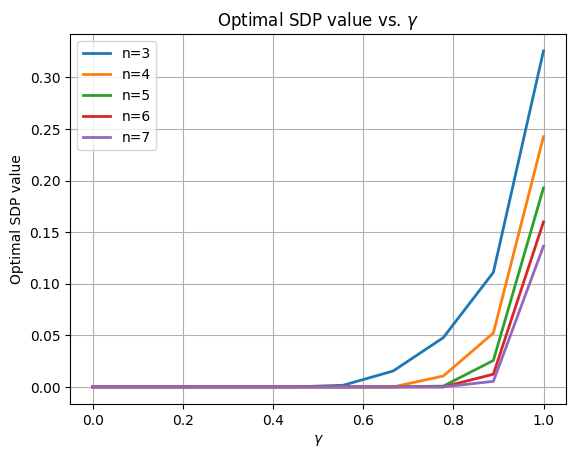

In [11]:
def plot_dims(step: int = 10, start_dim: int = 3, end_dim: int = 8) -> None:
    eps = 0.0001
    plot_vals = defaultdict(dict)
    for n in range(start_dim, end_dim):
        gammas, opt_vals = [], []
        e = np.ones(n)
        for gamma in np.linspace(0, 1-eps, step):
            gram = (1 - (gamma*(n-1))/(n-2)) * np.identity(n) + gamma * (e * e.T + 1/(n-2) * np.identity(n))
            vectors = vectors_from_gram_matrix(gram)

            gammas.append(gamma)
            opt_val, _ = state_exclusion(vectors, primal_dual="dual")
            opt_vals.append(opt_val)
        plot_vals[n]["gammas"] = gammas
        plot_vals[n]["opt_vals"] = opt_vals

    for k, v in plot_vals.items():
        plt.plot(v["gammas"], v["opt_vals"], "-", linewidth=2, label=f"n={k}")

    plt.legend(loc="upper left")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Optimal SDP value")
    plt.title(r"Optimal SDP value vs. $\gamma$")
    plt.grid()
    plt.show()


plot_dims()